# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Valence Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_valence_features_mean = pd.read_csv(get_deam_path('processed/features/normalised_essentia_best_valence_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_valence_features_mean = df_essentia_best_valence_features_mean[df_essentia_best_valence_features_mean.columns[1:]]

df_essentia_best_valence_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,2,0.023745,0.224209,0.054855,0.087567,0.069568,0.373016,0.392382,0.631265,0.625832,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,3,0.082083,0.348482,0.211289,0.019437,0.338074,0.357421,0.402792,0.543954,0.677312,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,4,0.018062,0.213582,0.084731,0.090074,0.135489,0.513626,0.661722,0.554446,0.593904,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,5,0.016018,0.181322,0.041096,0.086854,0.063757,0.378601,0.651524,0.395875,0.900862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,7,0.107675,0.349349,0.197274,0.017629,0.260381,0.637566,0.181959,0.602087,0.450784,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.013781,0.186248,0.077709,0.077239,0.093014,0.402743,0.476088,0.626271,0.772039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,1997,0.012825,0.189153,0.073405,0.089305,0.078782,0.288810,0.471430,0.576407,0.551288,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,1998,0.016787,0.199106,0.055710,0.170043,0.097281,0.548471,0.467379,0.654543,0.722595,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,1999,0.022245,0.224935,0.054033,0.087392,0.090900,0.508727,0.255286,0.625434,0.669501,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [4]:
df_essentia_best_valence_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 743 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    song_id                                  int64  
 1    lowlevel.melbands_kurtosis.mean          float64
 2    lowlevel.melbands_skewness.mean          float64
 3    lowlevel.spectral_energy.mean            float64
 4    lowlevel.zerocrossingrate.mean           float64
 5    rhythm.beats_loudness.mean               float64
 6    rhythm.onset_rate                        float64
 7    tonal.chords_strength.mean               float64
 8    tonal.hpcp_entropy.mean                  float64
 9    tonal.key_edma.strength                  float64
 10   tonal.key_temperley.strength             float64
 11   lowlevel.gfcc.cov_0                      float64
 12   lowlevel.gfcc.cov_1                      float64
 13   lowlevel.gfcc.cov_2                      float64
 14   lowlev

Join both the featureset and annotation set together

In [5]:
df_essentia_best_valence_features_mean_whole = pd.merge(df_essentia_best_valence_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_valence_features_mean_whole = df_essentia_best_valence_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_valence_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,0.023745,0.224209,0.054855,0.087567,0.069568,0.373016,0.392382,0.631265,0.625832,0.593381,...,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672,-0.475,-0.500
1,0.082083,0.348482,0.211289,0.019437,0.338074,0.357421,0.402792,0.543954,0.677312,0.677951,...,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942,-0.375,-0.425
2,0.018062,0.213582,0.084731,0.090074,0.135489,0.513626,0.661722,0.554446,0.593904,0.570916,...,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057,0.175,0.125
3,0.016018,0.181322,0.041096,0.086854,0.063757,0.378601,0.651524,0.395875,0.900862,0.900318,...,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199,-0.150,0.075
4,0.107675,0.349349,0.197274,0.017629,0.260381,0.637566,0.181959,0.602087,0.450784,0.432106,...,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.077239,0.093014,0.402743,0.476088,0.626271,0.772039,0.770549,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164,-0.275,0.225
1740,0.012825,0.189153,0.073405,0.089305,0.078782,0.288810,0.471430,0.576407,0.551288,0.577018,...,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132,0.075,-0.275
1741,0.016787,0.199106,0.055710,0.170043,0.097281,0.548471,0.467379,0.654543,0.722595,0.743935,...,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058,0.350,0.300
1742,0.022245,0.224935,0.054033,0.087392,0.090900,0.508727,0.255286,0.625434,0.669501,0.701341,...,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_valence_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,0.023745,0.224209,0.054855,0.087567,0.069568,0.373016,0.392382,0.631265,0.625832,0.593381,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,0.082083,0.348482,0.211289,0.019437,0.338074,0.357421,0.402792,0.543954,0.677312,0.677951,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,0.018062,0.213582,0.084731,0.090074,0.135489,0.513626,0.661722,0.554446,0.593904,0.570916,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,0.016018,0.181322,0.041096,0.086854,0.063757,0.378601,0.651524,0.395875,0.900862,0.900318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,0.107675,0.349349,0.197274,0.017629,0.260381,0.637566,0.181959,0.602087,0.450784,0.432106,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.077239,0.093014,0.402743,0.476088,0.626271,0.772039,0.770549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,0.012825,0.189153,0.073405,0.089305,0.078782,0.288810,0.471430,0.576407,0.551288,0.577018,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,0.016787,0.199106,0.055710,0.170043,0.097281,0.548471,0.467379,0.654543,0.722595,0.743935,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,0.022245,0.224935,0.054033,0.087392,0.090900,0.508727,0.255286,0.625434,0.669501,0.701341,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 297

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 742])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5630327456964119
Epoch 2, Loss: 0.5615221902584654
Epoch 3, Loss: 0.5602083147398167
Epoch 4, Loss: 0.5590723028544291
Epoch 5, Loss: 0.5581256532398259
Epoch 6, Loss: 0.5573786076499326
Epoch 7, Loss: 0.5568248778455462
Epoch 8, Loss: 0.556464398245238
Epoch 9, Loss: 0.556269043157121
Epoch 10, Loss: 0.556203114751745
Epoch 11, Loss: 0.5562259936778053
Epoch 12, Loss: 0.5563005981577871
Epoch 13, Loss: 0.5563972342579414
Epoch 14, Loss: 0.556492969939803
Epoch 15, Loss: 0.5565666818863269
Epoch 16, Loss: 0.5566051538777079
Epoch 17, Loss: 0.5566063853658676
Epoch 18, Loss: 0.5565706711029531
Epoch 19, Loss: 0.5565078577016411
Epoch 20, Loss: 0.5564313260828204
Epoch 21, Loss: 0.5563499628748727
Epoch 22, Loss: 0.556278311619719
Epoch 23, Loss: 0.556217769160505
Epoch 24, Loss: 0.5561726259145318
Epoch 25, Loss: 0.5561436894440923
Epoch 26, Loss: 0.5561295957660507
Epoch 27, Loss: 0.55612289712465
Epoch 28, Loss: 0.5561198157225109
Epoch 29, Loss: 0.556127479004088
Epo

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 742])


Generating scores

In [43]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [44]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2281730579618942
Valence RMSE: 0.21951736346920894
Arousal RMSE: 0.23651218973848062
Test R^2 score: tensor([0.4160, 0.4461], dtype=torch.float64)
Test R^2 score (overall): 0.4310655110590097


In [45]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_valence_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[-0.0092, -0.0358],
        [-0.0350, -0.0678],
        [-0.0023, -0.0275],
        [-0.0253, -0.0558],
        [-0.0255, -0.0560],
        [-0.0337, -0.0662],
        [-0.0360, -0.0691],
        [-0.0063, -0.0323],
        [-0.0331, -0.0655],
        [-0.0046, -0.0301],
        [-0.0055, -0.0312],
        [-0.0329, -0.0652],
        [-0.0361, -0.0693],
        [-0.0139, -0.0416],
        [-0.0047, -0.0302],
        [-0.0333, -0.0657],
        [-0.0354, -0.0683],
        [-0.0170, -0.0455],
        [-0.0003, -0.0252],
        [-0.0348, -0.0675],
        [-0.0355, -0.0685],
        [-0.0293, -0.0608],
        [-0.0368, -0.0701],
        [-0.0329, -0.0652],
        [-0.0030, -0.0282],
        [-0.0219, -0.0516],
        [-0.0148, -0.0427],
        [-0.0201, -0.0493],
        [-0.0155, -0.0436],
        [-0.0060, -0.0318],
        [-0.0364, -0.0696],
        [-0.0075, -0.0338],
        [-0.0041, -0.0295],
        [-0.0263, -0.0571],
        [-0.0336, -0.0661],
        [-0.0291, -0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.0345, 0.0494], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5630327456964119
Training completed.
Training completed.
Testing model...
Test RMSE: 0.31005186453368144
Valence RMSE: 0.2884879785014238
Arousal RMSE: 0.3302105444436726
Test R^2 score: tensor([-0.0086, -0.0797], dtype=torch.float64)
Test R^2 score (overall): -0.04413828893328642
Num of epochs: 2
Epoch 1, Loss: 0.5630327456964119
Epoch 2, Loss: 0.5615221902584654
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30843631378957814
Valence RMSE: 0.2880480546110907
Arousal RMSE: 0.3275579911450374
Test R^2 score: tensor([-0.0055, -0.0624], dtype=torch.float64)
Test R^2 score (overall): -0.03396334861544981
Num of epochs: 3
Epoch 1, Loss: 0.5630327456964119
Epoch 2, Loss: 0.5615221902584654
Epoch 3, Loss: 0.5602083147398167
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30703483163745166
Valence RMSE: 0.2876927544655842
Arousal RMSE: 0.32522861913626494
Test R^2 score: tensor([-0.0031, -0.0473], dtype=torch.float

### Plot the graph to visualise the relationship the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

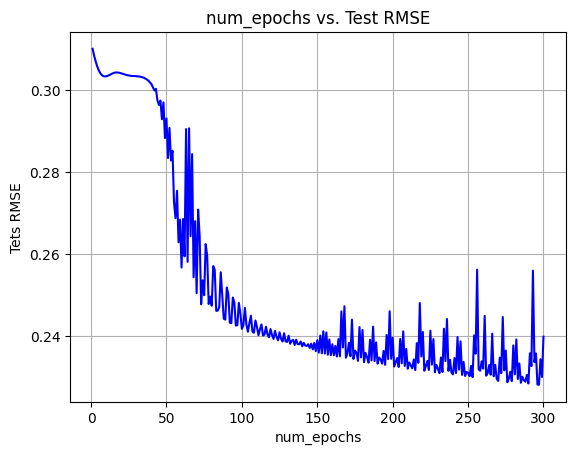

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2281730579618942
Corresponding R^2 SCore: 0.4310655110590097
Corresponding num_epochs: 297


Test R^2 Score vs. num_epochs

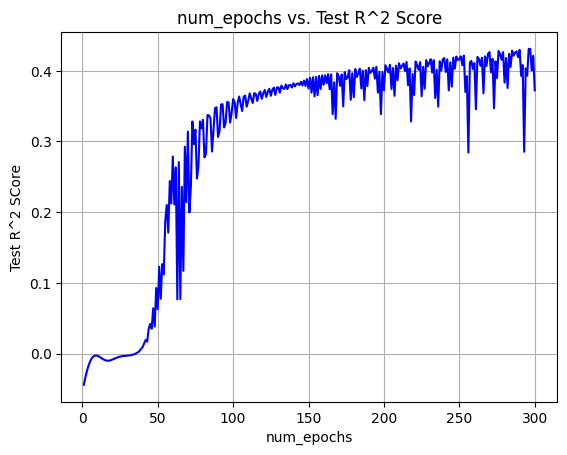

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4310655110590097
Corresponding RMSE: 0.2281730579618942
Corresponding num_epochs: 297


Test Adjusted R^2 Score (Valence) vs. num_epochs

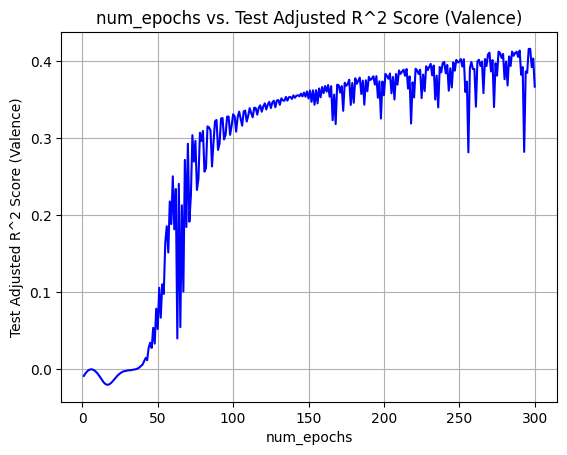

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.41601136044407594
Corresponding RMSE: 0.2281730579618942
Corresponding num_epochs: 297


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

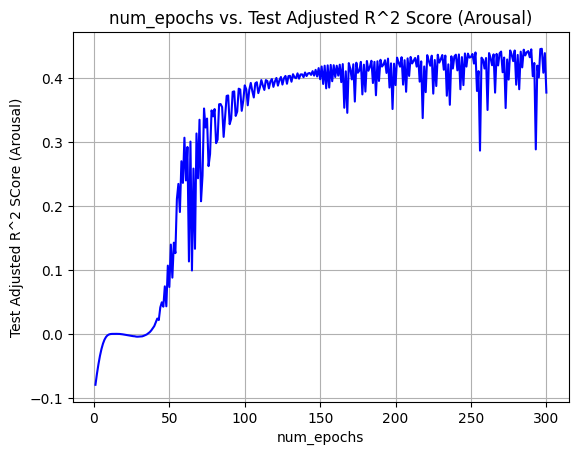

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.44611966167394346
Corresponding RMSE: 0.2281730579618942
Corresponding num_epochs: 297
